# Fantasy Football Quantile Predictions (v2)

This notebook uses the improved model from `SI670_Final_Project_Model_v4` with more sophisticated features:
- **Volatility features**: rolling std, MAE, deviation from average
- **Workload features**: play share, target share
- **Opponent features**: defensive EPA allowed
- **Spike rate**: Probability of boom games

## What You'll Get
- **pred_10 (Floor)**: Safe minimum - player should score above this 90% of the time
- **pred_50 (Median)**: Expected score - most likely outcome
- **pred_90 (Ceiling)**: Upside - player could score this high 10% of the time


## Step 1: Connect to ESPN League


In [ ]:
# Connect to ESPN Fantasy League
from espn_api.football import League
import nfl_data_py as nfl
import pandas as pd
import numpy as np

league = League(
    league_id=567575, 
    year=2025,  # ESPN Fantasy Year (2024-25 NFL Season)
    espn_s2='AECVN3FcAWfB56xxM5SnNVqsxq9soOxMmzDH1CfYYOkX3KIrzeGSsTMZ0CwJLPQoBYxLMp59ILoZ0CvUnTrBbU15b2PwD1v9fZRoO5iMb%2Fy%2FWPaOqPwlwSx2ShvBAt%2BSqJxtboHzcpSuSOgASzSNx4divXOEc4aVZjnOx7qRJ9YbE800NnLCNiLMBpaHjdZg%2BMN6vwCInJrKejPDXsmdjo%2FIkV0IfCLQHr6QHyJjLhqOwAPozqNPyGa1ZZT8DOxA%2BmpTsa5v9cgfJ4V%2BVZzxzr95KxBS0k%2BYJMt7OWSdA%2B2yUQ%3D%3D', 
    swid='{280AA84B-DE12-4B3D-80F2-283BF634242B}'
)
team = league.teams[9]  # <-- Change index to select your team
print(f"Connected to league. Your team: {team.team_name}")


Connected to league. Your team: Math Guys


## Step 2: Load Data & Build Features

Using the Model_v4 feature engineering approach with:
- Player time-series & volatility features
- Workload/opportunity features  
- Opponent defensive features
- Spike (boom game) probability


In [6]:
# Half-PPR scoring rules
scoring_rules = {
    'pass_yd': 0.04, 'pass_td': 4,
    'rush_yd': 0.1, 'rush_td': 6,
    'rec_yd': 0.1, 'rec_td': 6,
    'rec': 0.5,
    'int': -2, 'fumble_lost': -2,
    'qb_kneel_yd': -0.1
}

def calculate_fantasy_points_per_play(df: pd.DataFrame, scoring_rules: dict) -> pd.DataFrame:
    """Calculates all fantasy points earned on a single play based on half-PPR rules."""
    df = df.copy()
    
    # Passing Points (QB)
    df['fp_pass'] = (df['passing_yards'].fillna(0) * scoring_rules['pass_yd']) + \
                    (df['pass_touchdown'].fillna(0) * scoring_rules['pass_td'])
    
    # Rushing Points (RB/QB)
    df['fp_rush'] = (df['rushing_yards'].fillna(0) * scoring_rules['rush_yd']) + \
                    (df['rush_touchdown'].fillna(0) * scoring_rules['rush_td'])
    
    # Receiving Points - Calculate conditionally to prevent leakage
    is_reception = df['complete_pass'].fillna(0) == 1
    df['fp_rec'] = np.where(is_reception, 
        (df['receiving_yards'].fillna(0) * scoring_rules['rec_yd']) + \
        (df['pass_touchdown'].fillna(0) * scoring_rules['rec_td']) + \
        (df['complete_pass'].fillna(0) * scoring_rules['rec']),
        0
    )
    
    # Interception (for primary passer)
    df['fp_int'] = df['interception'].fillna(0) * scoring_rules['int']
    
    # Fumble Lost (for primary ball carrier/or receiver)
    df['fp_fumble_lost'] = df['fumble_lost'].fillna(0) * scoring_rules['fumble_lost']
    df['fp_fumble_penalty'] = df['fp_fumble_lost'].fillna(0)  # Separate column for attribution
    
    # QB Kneel Adjustment
    df['fp_kneel'] = np.where(df['play_type'] == 'qb_kneel',
                              df['yards_gained'].fillna(0) * scoring_rules['qb_kneel_yd'], 0)
    return df

def calculate_weekly_fantasy_points_final(df: pd.DataFrame) -> pd.DataFrame:
    """Aggregates all fantasy points earned by a player across a week."""
    df = df.copy()
    
    # Calculate the total points for each respective player id
    df['fp_pass_total'] = df['fp_pass'].fillna(0) + df['fp_int'].fillna(0) + df['fp_kneel'].fillna(0)
    df['fp_rush_total'] = df['fp_rush'].fillna(0)
    df['fp_rec_total'] = df['fp_rec'].fillna(0)

    id_vars = ['season', 'week']
    
    contributions_map = {
        'passer_player_id': 'fp_pass_total',
        'rusher_player_id': 'fp_rush_total',
        'receiver_player_id': 'fp_rec_total',
        
        # Apply Fumble PENALTY (Negative Points) to the three primary roles 
        # to ensure the correct player is penalized for losing the ball.
        'passer_player_id_fumble': 'fp_fumble_penalty', 
        'rusher_player_id_fumble': 'fp_fumble_penalty',
        'receiver_player_id_fumble': 'fp_fumble_penalty',
    }

    contributions = []
    for id_col_raw, point_col in contributions_map.items():
        id_col = id_col_raw.replace('_fumble', '')
        
        temp_df = df.rename(columns={id_col: 'player_id', point_col: 'points'})
        contributions.append(temp_df[id_vars + ['player_id', 'points']])

    # Stack contributions and drop any missing player ids
    df_all_points = pd.concat(contributions, ignore_index=True)
    df_all_points.dropna(subset=['player_id'], inplace=True)

    # Group by week and season for each respective player id and return the table
    df_target_Y = df_all_points.groupby(id_vars + ['player_id'])['points'].sum().reset_index()
    
    return df_target_Y.rename(columns={'points': 'Y_target_points'})


In [ ]:
# Load NFL play-by-play data (2015-2024 for richer history)
print("Loading NFL play-by-play data (this may take a minute)...")
df = nfl.import_pbp_data([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

# Keep fantasy-relevant plays
fantasy_play_types = ['pass', 'run', 'qb_kneel']
exclude_play_types = ['no_play', 'qb_spike', 'field_goal', 'extra_point', 'punt', 'kickoff']

df_fantasy_plays = df[
    df['play_type'].isin(fantasy_play_types) & ~df['play_type'].isin(exclude_play_types)
].copy()

# Fix: Impute Rusher ID for QB Kneels
df_fantasy_plays['rusher_player_id'] = np.where(
    (df_fantasy_plays['play_type'] == 'qb_kneel') & 
    df_fantasy_plays['rusher_player_id'].isnull(), 
    df_fantasy_plays['passer_player_id'], 
    df_fantasy_plays['rusher_player_id']
)

# Filter out penalties and 2-point attempts
df_mdl1 = df_fantasy_plays[
    (df_fantasy_plays['penalty'] == 0) & 
    (df_fantasy_plays['two_point_attempt'] == 0)
].copy()

# Select modeling columns
mdl_cols = [
    'game_id', 'play_id', 'season', 'week', 'posteam', 'defteam',
    'passer_player_id', 'rusher_player_id', 'receiver_player_id',
    'passing_yards', 'pass_touchdown', 'interception',
    'rushing_yards', 'rush_touchdown', 'fumble_lost',
    'receiving_yards', 'complete_pass',
    'play_type', 'yards_gained', 'epa', 'cpoe'
]

df_mdl0 = df_mdl1[mdl_cols].copy()

# Calculate per-play fantasy points
df_mdl1 = calculate_fantasy_points_per_play(df_mdl0, scoring_rules)

# Weekly target Y per player
df_target_Y = calculate_weekly_fantasy_points_final(df_mdl1)
print(f"Target variable created. Total player-weeks: {len(df_target_Y)}")


Loading NFL play-by-play data (this may take a minute)...
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.
Target variable created. Total player-weeks: 54213


In [8]:
# BLOCK 1: Feature Aggregation & Position Inference (from Model_v4)

feature_agg_rules = {
    'passing_yards': 'sum',
    'rushing_yards': 'sum',
    'receiving_yards': 'sum',
    'pass_touchdown': 'sum',
    'rush_touchdown': 'sum',
    'interception': 'sum',
    'complete_pass': 'sum',
    'epa': 'mean',
    'cpoe': 'mean',
}

id_vars = ['season', 'week']
feature_cols = list(feature_agg_rules.keys())
context_cols = ['posteam', 'defteam']

df_select = df_mdl1[id_vars + feature_cols + context_cols + 
    ['passer_player_id', 'rusher_player_id', 'receiver_player_id']].copy()

df_X_long = pd.melt(
    df_select,
    id_vars=id_vars + feature_cols + context_cols,
    value_vars=['passer_player_id', 'rusher_player_id', 'receiver_player_id'],
    var_name='role_type',
    value_name='player_id'
)
df_X_long.dropna(subset=['player_id'], inplace=True)

group_keys = ['season', 'week', 'player_id', 'posteam', 'defteam']
df_features_X = df_X_long.groupby(group_keys).agg(feature_agg_rules).reset_index()

df_counts = df_X_long.groupby(group_keys).size().reset_index(name='total_plays_involved')
df_features_X = pd.merge(df_features_X, df_counts, on=group_keys, how='left')

# Position Inference
role_counts = df_X_long.groupby(['player_id', 'role_type']).size().reset_index(name='count')
player_role_summary = role_counts.pivot(index='player_id', columns='role_type', values='count').fillna(0)

def infer_position(row):
    pass_count = row.get('passer_player_id', 0)
    rush_count = row.get('rusher_player_id', 0)
    rec_count = row.get('receiver_player_id', 0)
    if pass_count >= 50:
        return 'QB'
    if rush_count >= 10 and rush_count > rec_count * 2:
        return 'RB'
    if rec_count >= 10:
        return 'WR/TE'
    return 'OTH'

player_role_summary['position'] = player_role_summary.apply(infer_position, axis=1)
player_position_map = player_role_summary['position']

print("Block 1: Aggregation & Position Inference Complete.")


Block 1: Aggregation & Position Inference Complete.


In [9]:
# BLOCK 2: Feature Engineering (Lagged, Volatility, Opponent) - from Model_v4

# Merge features with target
df_final = pd.merge(
    df_features_X, 
    df_target_Y,    
    on=['season', 'week', 'player_id'],
    how='left'
)
df_final['Y_target_points'] = df_final['Y_target_points'].fillna(0)
df_final.sort_values(by=['player_id', 'season', 'week'], inplace=True)

# Add Player Opportunity Share (Workload Metric)
team_opportunities = df_final.groupby(['season', 'week', 'posteam'])['total_plays_involved'].sum().rename('team_total_plays').reset_index()
df_final = df_final.merge(team_opportunities, on=['season', 'week', 'posteam'], how='left')
df_final['play_share'] = df_final['total_plays_involved'] / df_final['team_total_plays']

# --- A. PLAYER TIME-SERIES & VOLATILITY FEATURES ---
df_final['Y_lag_1'] = df_final.groupby('player_id')['Y_target_points'].shift(1)
df_final['Y_roll_avg_3'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)
df_final['Y_cum_avg'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).expanding(min_periods=1).mean()
)

# Volatility (Risk Metrics)
df_final['Y_roll_std_3'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).std()
)
df_final['Y_MAE_roll_3'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).apply(lambda y: np.mean(np.abs(y - np.mean(y))), raw=True)
)
df_final['Y_cum_std'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).expanding(min_periods=1).std() 
)
df_final['play_share_roll_std_3'] = df_final.groupby('player_id')['play_share'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).std()
)

# Deviation from Cumulative Average (regime change signal)
df_final['Y_dev_from_cum_avg'] = df_final['Y_roll_avg_3'] - df_final['Y_cum_avg']

# --- B. OPPONENT EFFICIENCY FEATURES ---
print("Calculating Defensive Performance Metrics...")

df_defense_metrics = df_mdl1[['season', 'week', 'defteam', 'epa']].copy()
df_defense_metrics.rename(columns={'defteam': 'defense_team_id'}, inplace=True)

df_defense_agg = df_defense_metrics.groupby(['season', 'week', 'defense_team_id']).agg(
    epa_allowed_game=('epa', 'mean')
).reset_index()

df_defense_agg.sort_values(by=['defense_team_id', 'season', 'week'], inplace=True)
df_defense_agg['Opp_EPA_Mean'] = df_defense_agg.groupby('defense_team_id')['epa_allowed_game'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

df_def_stats_merge = df_defense_agg[['season', 'week', 'defense_team_id', 'Opp_EPA_Mean']].copy()

# Merge Defensive Stats
df_final = pd.merge(
    df_final,
    df_def_stats_merge,
    left_on=['season', 'week', 'defteam'], 
    right_on=['season', 'week', 'defense_team_id'],
    how='left'
)

# --- C. TARGET SHARE ---
team_pass_attempts = df_mdl1[df_mdl1['play_type'] == 'pass'].copy()
team_pass_attempts = team_pass_attempts.groupby(['season', 'week', 'posteam']).size().reset_index(name='Team_Pass_Attempts')
df_final = pd.merge(df_final, team_pass_attempts, on=['season', 'week', 'posteam'], how='left')
df_final['Team_Pass_Attempts'] = df_final['Team_Pass_Attempts'].fillna(0)

df_final['Target_Share'] = np.where(
    df_final['Team_Pass_Attempts'] > 0, 
    df_final['complete_pass'] / df_final['Team_Pass_Attempts'], 
    0
)
df_final['Target_Share_lag_1'] = df_final.groupby('player_id')['Target_Share'].shift(1)

# --- D. SPIKE RATE (Boom Game Probability) ---
SPIKE_THRESHOLD = 20.0
df_final['is_spike'] = (df_final['Y_target_points'] >= SPIKE_THRESHOLD).astype(int)
df_final['Y_Spike_Rate_5'] = df_final.groupby('player_id')['is_spike'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# --- D. FINAL CLEANUP ---
df_final.drop(columns=['defense_team_id', 'team_total_plays', 'Team_Pass_Attempts', 'Target_Share'], inplace=True)

# Fill NaNs for all new features (first few weeks/first few games)
new_features_to_fill = [col for col in df_final.columns if col not in group_keys + ['Y_target_points']]
df_final[new_features_to_fill] = df_final[new_features_to_fill].fillna(0)

print("\nBlock 2: Feature Engineering Complete. df_final is ready.")
print(f"df_final shape: {df_final.shape}")


Calculating Defensive Performance Metrics...

Block 2: Feature Engineering Complete. df_final is ready.
df_final shape: (54213, 29)


## Step 3: Train Quantile Models

Using the Model_v4 approach with:
- Leakage removal (no raw game stats in X)
- OneHotEncoder for categorical features
- HistGradientBoostingRegressor for quantiles


In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

id_cols = ['season', 'week', 'player_id']
target_col = 'Y_target_points'

# Features that leak the answer (raw game stats)
LEAKAGE_FEATURES = [
    'passing_yards', 'rushing_yards', 'receiving_yards', 'pass_touchdown', 
    'rush_touchdown', 'interception', 'complete_pass', 
    'epa', 'cpoe',  # Also remove - strong proxies for outcome
]

# Create df_features, removing leakage and target
df_features = df_final.drop(columns=[target_col] + LEAKAGE_FEATURES)

# Add position as feature
df_features['position'] = df_features['player_id'].map(player_position_map)
df_features['position'] = df_features['position'].fillna('OTH')

# Drop ID columns for feature matrix
FINAL_ID_COLUMNS_TO_DROP = ['season', 'week', 'player_id']
X = df_features.drop(columns=FINAL_ID_COLUMNS_TO_DROP)

# Define feature types
categorical_features = ['posteam', 'defteam', 'position']
numerical_features = [col for col in X.columns if col not in categorical_features]

y = df_final[target_col]

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

# Chronological split (90/10)
split_point = int(len(X) * 0.90)
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]
ids_test = df_final[id_cols].iloc[split_point:]

print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")

# Transform data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


Numerical features (14): ['total_plays_involved', 'play_share', 'Y_lag_1', 'Y_roll_avg_3', 'Y_cum_avg', 'Y_roll_std_3', 'Y_MAE_roll_3', 'Y_cum_std', 'play_share_roll_std_3', 'Y_dev_from_cum_avg', 'Opp_EPA_Mean', 'Target_Share_lag_1', 'is_spike', 'Y_Spike_Rate_5']
Categorical features: ['posteam', 'defteam', 'position']

Train size: 48791, Test size: 5422


In [11]:
# Train Quantile Models
quantiles = [0.10, 0.50, 0.90]
y_preds = {}
models = {}

print("--- Training Quantile Models (Model_v4 Features) ---")
for q in quantiles:
    print(f"Training quantile {q}")
    model = HistGradientBoostingRegressor(
        loss='quantile',
        quantile=q,
        max_depth=8,
        learning_rate=0.01,
        max_iter=2000,
        random_state=321
    )
    model.fit(X_train_scaled, y_train)
    y_preds[q] = model.predict(X_test_scaled)
    models[q] = model
print("Finished training.\n")

# Evaluate
def pinball_loss(y_true, y_pred, q):
    err = y_true - y_pred
    return np.mean(np.where(err >= 0, q * err, (1 - q) * -err))

df_predictions = pd.DataFrame({
    'y_test': y_test.values,
    'pred_10': y_preds[0.10],
    'pred_50': y_preds[0.50],
    'pred_90': y_preds[0.90]
}, index=y_test.index)
df_predictions = df_predictions.join(ids_test)
df_predictions['position'] = df_predictions['player_id'].map(player_position_map)
df_predictions['position'] = df_predictions['position'].fillna('OTH')

mae = mean_absolute_error(df_predictions['y_test'], df_predictions['pred_50'])
coverage = ((df_predictions['y_test'] >= df_predictions['pred_10']) & 
            (df_predictions['y_test'] <= df_predictions['pred_90'])).mean() * 100
pb10 = pinball_loss(df_predictions['y_test'], df_predictions['pred_10'], 0.10)

print("--- Evaluation Summary (Model_v4 Features) ---")
print(f"MAE (Median Prediction): {mae:.2f}")
print(f"80% PI Coverage Actual: {coverage:.2f}%")
print(f"Pinball Loss (10th Quantile): {pb10:.4f}")


--- Training Quantile Models (Model_v4 Features) ---
Training quantile 0.1
Training quantile 0.5
Training quantile 0.9
Finished training.

--- Evaluation Summary (Model_v4 Features) ---
MAE (Median Prediction): 2.47
80% PI Coverage Actual: 76.72%
Pinball Loss (10th Quantile): 0.4358


## Step 4: Prepare for Roster Predictions

Build player name mapping and get latest historical features for each player.


In [12]:
import re
import unicodedata

# Get player ID crosswalk
ids = nfl.import_ids()
name_col_ids = 'name' if 'name' in ids.columns else 'full_name'
ids_map = ids[['gsis_id', name_col_ids]].dropna().drop_duplicates('gsis_id')
ids_map = ids_map.rename(columns={'gsis_id': 'player_id', name_col_ids: 'player_name'})

# Name normalization
SUFFIXES = {'jr','sr','ii','iii','iv','v'}
def normalize_name(s: str) -> str:
    if pd.isna(s):
        return ''
    s = unicodedata.normalize('NFKD', s).encode('ASCII', 'ignore').decode('ASCII')
    s = re.sub(r"[^a-zA-Z\s]", "", s).strip().lower()
    parts = [p for p in s.split() if p and p not in SUFFIXES]
    return " ".join(parts)

ids_map['name_norm'] = ids_map['player_name'].apply(normalize_name)

# Get latest season/week
latest_season = df_final['season'].max()
df_latest_season = df_final[df_final['season'] == latest_season].copy()
latest_week_in_data = int(df_latest_season['week'].max())

print(f"Latest data: {latest_season} week {latest_week_in_data}")

# Get each player's latest features (including position)
df_player_hist = df_latest_season.sort_values(['player_id', 'week']).groupby('player_id').last().reset_index()
df_player_hist['position'] = df_player_hist['player_id'].map(player_position_map).fillna('OTH')
df_player_hist = df_player_hist.merge(ids_map[['player_id', 'player_name', 'name_norm']], on='player_id', how='left')

print(f"Players with historical data: {len(df_player_hist)}")


Latest data: 2024 week 22
Players with historical data: 604


## Step 5: Your Roster Predictions

Generate quantile predictions for your ESPN roster using:
- **Historical patterns** (lagged values, volatility, spike rate)
- **Workload features** (play share, target share)
- **Opponent context** (defensive EPA)

**How to use these predictions**:
- **Need a safe floor?** Start players with high `pred_10` values
- **Need upside?** Start players with high `pred_90` values
- **Best overall?** Sort by `pred_50` (median expected points)


In [16]:
# Get ESPN roster predictions

# Find available weeks with projections
sample_stats = getattr(team.roster[0], 'stats', {})
available_weeks = sorted([w for w in sample_stats.keys() if w > 0 and 'projected_points' in sample_stats.get(w, {})])
print(f"Available ESPN projection weeks: {available_weeks}")

# Weeks to predict
weeks_to_predict = [13, 14, 15]

# Features used by model (must match training)
print(f"\nUsing {len(numerical_features)} features: {numerical_features[:10]}..." if len(numerical_features) > 10 else f"Using features: {numerical_features}")

for pred_week in weeks_to_predict:
    print(f"\n{'='*60}")
    print(f"WEEK {pred_week} PREDICTIONS (2025 Season)")
    print(f"{'='*60}")
    
    # Get ESPN roster info
    roster_data = []
    for p in team.roster:
        name = getattr(p, 'name', None)
        if name and 'D/ST' not in name:
            stats = getattr(p, 'stats', {}) or {}
            week_data = stats.get(pred_week, {})
            espn_weekly_proj = week_data.get('projected_points', 0) or 0
            actual_pts = week_data.get('points', None)
            roster_data.append({
                'player_name_espn': name,
                'espn_proj_pts': espn_weekly_proj,
                'actual_pts': actual_pts,
            })
    
    espn_df = pd.DataFrame(roster_data)
    espn_df['name_norm'] = espn_df['player_name_espn'].apply(normalize_name)
    
    # Get lag data from week before prediction
    lag_week = pred_week - 1
    df_lag_data = df_latest_season[df_latest_season['week'] == lag_week].copy()
    df_lag_data['position'] = df_lag_data['player_id'].map(player_position_map).fillna('OTH')
    df_lag_data = df_lag_data.merge(ids_map[['player_id', 'player_name', 'name_norm']], on='player_id', how='left')
    
    if len(df_lag_data) == 0:
        print(f"  Note: No week {lag_week} data, using most recent available data")
        df_lag_data = df_player_hist.copy()
    
    # Match ESPN roster to NFL data
    lag_cols = ['player_id', 'name_norm', 'posteam', 'defteam', 'position'] + numerical_features
    available_cols = [c for c in lag_cols if c in df_lag_data.columns]
    merged = espn_df.merge(df_lag_data[available_cols], on='name_norm', how='left')
    
    matched = merged[merged['player_id'].notna()].copy()
    unmatched = merged[merged['player_id'].isna()]['player_name_espn'].tolist()
    
    print(f"Matched {len(matched)} / {len(espn_df)} roster players")
    if unmatched:
        print(f"Unmatched: {unmatched}")
    
    if len(matched) == 0:
        print("No players matched, skipping this week.")
        continue
    
    # Build feature matrix for prediction
    # Need to create same structure as training (categorical + numerical)
    X_roster = matched[['posteam', 'defteam', 'position'] + numerical_features].copy()
    for col in numerical_features:
        if col not in X_roster.columns:
            X_roster[col] = 0
    X_roster = X_roster.fillna(0)
    
    # Ensure column order matches training
    X_roster = X_roster[categorical_features + numerical_features]
    
    # Transform and predict
    X_roster_scaled = preprocessor.transform(X_roster)
    
    # Pure quantile predictions
    matched['pred_10'] = models[0.10].predict(X_roster_scaled)
    matched['pred_50'] = models[0.50].predict(X_roster_scaled)
    matched['pred_90'] = models[0.90].predict(X_roster_scaled)
    
    # Fix quantile crossing
    for idx in matched.index:
        q10, q50, q90 = matched.loc[idx, 'pred_10'], matched.loc[idx, 'pred_50'], matched.loc[idx, 'pred_90']
        sorted_quantiles = sorted([q10, q50, q90])
        matched.loc[idx, 'pred_10'] = sorted_quantiles[0]
        matched.loc[idx, 'pred_50'] = sorted_quantiles[1]
        matched.loc[idx, 'pred_90'] = sorted_quantiles[2]
    
    # Display results
    print(f"\npred_10 = floor (90% chance to beat), pred_50 = median, pred_90 = ceiling")
    
    output = matched[['player_name_espn', 'espn_proj_pts', 'actual_pts', 'pred_10', 'pred_50', 'pred_90']].copy()
    output = output.rename(columns={'player_name_espn': 'player', 'espn_proj_pts': 'espn_proj', 'actual_pts': 'actual'})
    
    # Remove bye week players
    bye_players = output[output['espn_proj'] == 0]['player'].tolist()
    if bye_players:
        print(f"Excluding bye week/inactive players: {bye_players}")
    output = output[output['espn_proj'] > 0]
    
    output = output.sort_values('pred_50', ascending=False).reset_index(drop=True)
    
    # Round for readability
    for col in ['pred_10', 'pred_50', 'pred_90', 'espn_proj']:
        output[col] = output[col].round(1)
    if 'actual' in output.columns:
        output['actual'] = output['actual'].round(1)
    
    display(output)


Available ESPN projection weeks: [14, 15]

Using 14 features: ['total_plays_involved', 'play_share', 'Y_lag_1', 'Y_roll_avg_3', 'Y_cum_avg', 'Y_roll_std_3', 'Y_MAE_roll_3', 'Y_cum_std', 'play_share_roll_std_3', 'Y_dev_from_cum_avg']...

WEEK 13 PREDICTIONS (2025 Season)
Matched 10 / 16 roster players
Unmatched: ['Bijan Robinson', 'Davante Adams', 'Tee Higgins', 'Hollywood Brown', 'Brock Purdy', 'Kirk Cousins']

pred_10 = floor (90% chance to beat), pred_50 = median, pred_90 = ceiling
Excluding bye week/inactive players: ['Trey McBride', 'Kyren Williams', 'Josh Jacobs', 'DJ Moore', 'Tucker Kraft', 'Javonte Williams', 'Jalen Hurts', 'Justin Herbert', 'Theo Johnson', 'Troy Franklin']


,player,espn_proj,actual,pred_10,pred_50,pred_90



WEEK 14 PREDICTIONS (2025 Season)
Matched 15 / 16 roster players
Unmatched: ['Hollywood Brown']

pred_10 = floor (90% chance to beat), pred_50 = median, pred_90 = ceiling
Excluding bye week/inactive players: ['Tucker Kraft', 'Brock Purdy', 'Theo Johnson']


,player,espn_proj,actual,pred_10,pred_50,pred_90
0,Bijan Robinson,18.4,8.4,20.6,24.9,32.8
1,Justin Herbert,16.5,12.2,6.3,14.5,18.7
2,Kirk Cousins,10.7,2.5,6.5,14.5,18.6
3,Jalen Hurts,19.8,0.4,6.0,13.8,18.5
4,Josh Jacobs,20.3,16.2,7.2,13.6,19.4
5,Davante Adams,14.5,4.9,6.1,13.5,18.7
6,DJ Moore,10.7,0.1,6.0,13.1,19.0
7,Tee Higgins,11.2,24.2,6.1,11.9,17.6
8,Trey McBride,12.3,8.3,5.6,11.0,17.0
9,Kyren Williams,13.0,16.7,4.8,9.2,16.9



WEEK 15 PREDICTIONS (2025 Season)
Matched 12 / 16 roster players
Unmatched: ['Javonte Williams', 'Hollywood Brown', 'Theo Johnson', 'Troy Franklin']

pred_10 = floor (90% chance to beat), pred_50 = median, pred_90 = ceiling
Excluding bye week/inactive players: ['Tee Higgins', 'Tucker Kraft']


,player,espn_proj,actual,pred_10,pred_50,pred_90
0,Jalen Hurts,20.5,22.9,20.8,24.8,31.4
1,Josh Jacobs,14.2,22.2,20.6,24.7,32.3
2,Kyren Williams,13.0,21.3,20.6,24.6,31.6
3,Brock Purdy,19.7,26.2,20.8,24.2,29.9
4,Davante Adams,14.3,9.1,20.5,23.4,28.6
5,Justin Herbert,16.1,10.4,6.2,13.9,18.4
6,Kirk Cousins,12.6,27.9,6.1,13.4,18.0
7,Bijan Robinson,19.9,25.5,6.7,13.1,18.3
8,Trey McBride,11.1,32.4,6.1,12.4,17.3
9,DJ Moore,8.9,20.9,4.5,8.9,16.7


## Bonus: Visualize Quantile Curves by Position


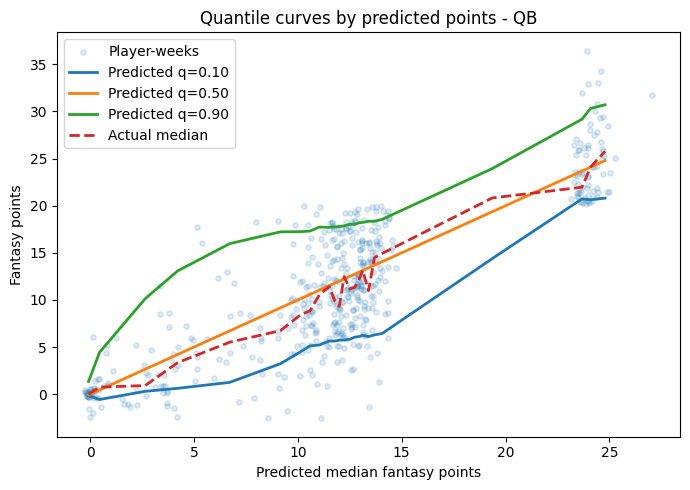

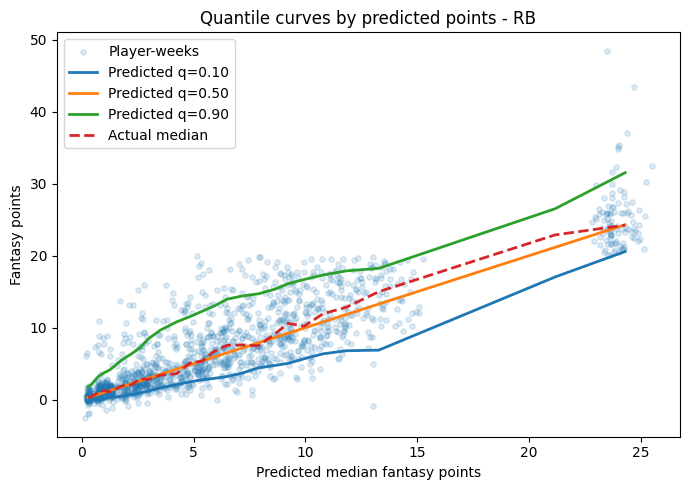

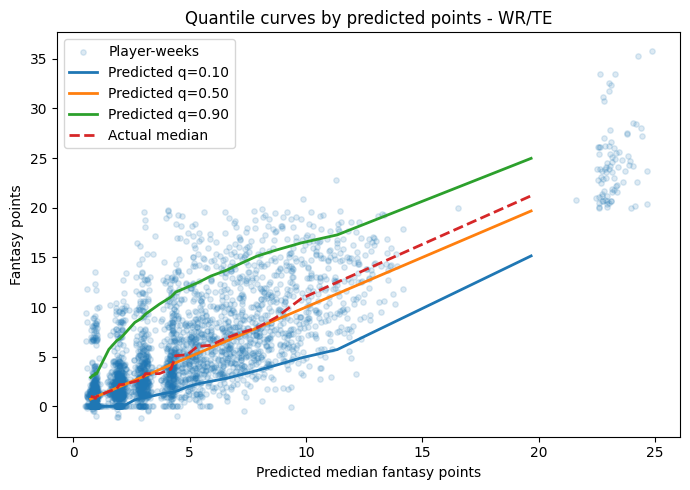

In [14]:
import matplotlib.pyplot as plt

def plot_quantile_curves_by_position(df_predictions, position, n_bins=25):
    """
    Make a quantile fan plot for a single position:
      - x-axis: predicted median points (pred_50)
      - lines: avg predicted 10/50/90 quantiles
      - line: actual median in each bin (ground truth)
      - background: scatter of individual weeks
    """
    df_pos = df_predictions[df_predictions['position'] == position].copy()
    if df_pos.empty:
        print(f"No rows found for position {position}")
        return

    df_pos = df_pos.sort_values('pred_50')
    nbins = min(n_bins, max(5, len(df_pos) // 20))
    df_pos['pred_bin'] = pd.qcut(df_pos['pred_50'], q=nbins, duplicates='drop')

    grouped = df_pos.groupby('pred_bin')
    x = grouped['pred_50'].mean()
    pred_q10 = grouped['pred_10'].mean()
    pred_q50 = grouped['pred_50'].mean()
    pred_q90 = grouped['pred_90'].mean()
    actual_med = grouped['y_test'].median()

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(df_pos['pred_50'], df_pos['y_test'], alpha=0.15, s=15, label='Player-weeks')
    ax.plot(x, pred_q10, linewidth=2, label='Predicted q=0.10')
    ax.plot(x, pred_q50, linewidth=2, label='Predicted q=0.50')
    ax.plot(x, pred_q90, linewidth=2, label='Predicted q=0.90')
    ax.plot(x, actual_med, linewidth=2, linestyle='--', label='Actual median')

    ax.set_xlabel('Predicted median fantasy points')
    ax.set_ylabel('Fantasy points')
    ax.set_title(f'Quantile curves by predicted points - {position}')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot for each position
plot_quantile_curves_by_position(df_predictions, position='QB')
plot_quantile_curves_by_position(df_predictions, position='RB')
plot_quantile_curves_by_position(df_predictions, position='WR/TE')
